In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
import seaborn as sns
from utils.visualize import custom_histogram
from sklearn.model_selection import train_test_split

# Continuous data preparation
## 1. Load data + visualize

In [2]:
# Specify directory
temp_data_dir = '../data/temp/'

# Save data 
X_train = pd.read_csv(temp_data_dir + 'X_train.csv', index_col = 0)
y_train = pd.read_csv(temp_data_dir + 'y_train.csv', index_col = 0)
X_dev = pd.read_csv(temp_data_dir + 'X_dev.csv', index_col = 0)
y_dev = pd.read_csv(temp_data_dir + 'y_dev.csv', index_col = 0)

In [9]:
# Select data
df = X_dev

# Visualize all continuous variables 
columns_cont = [] 

for i in df.dtypes.index:
    if df.dtypes.loc[i] == 'float64':
        columns_cont.append(i)

In [10]:
df[columns_cont].dtypes

age    float64
TSH    float64
T3     float64
TT4    float64
T4U    float64
FTI    float64
dtype: object

<Figure size 1440x1440 with 0 Axes>

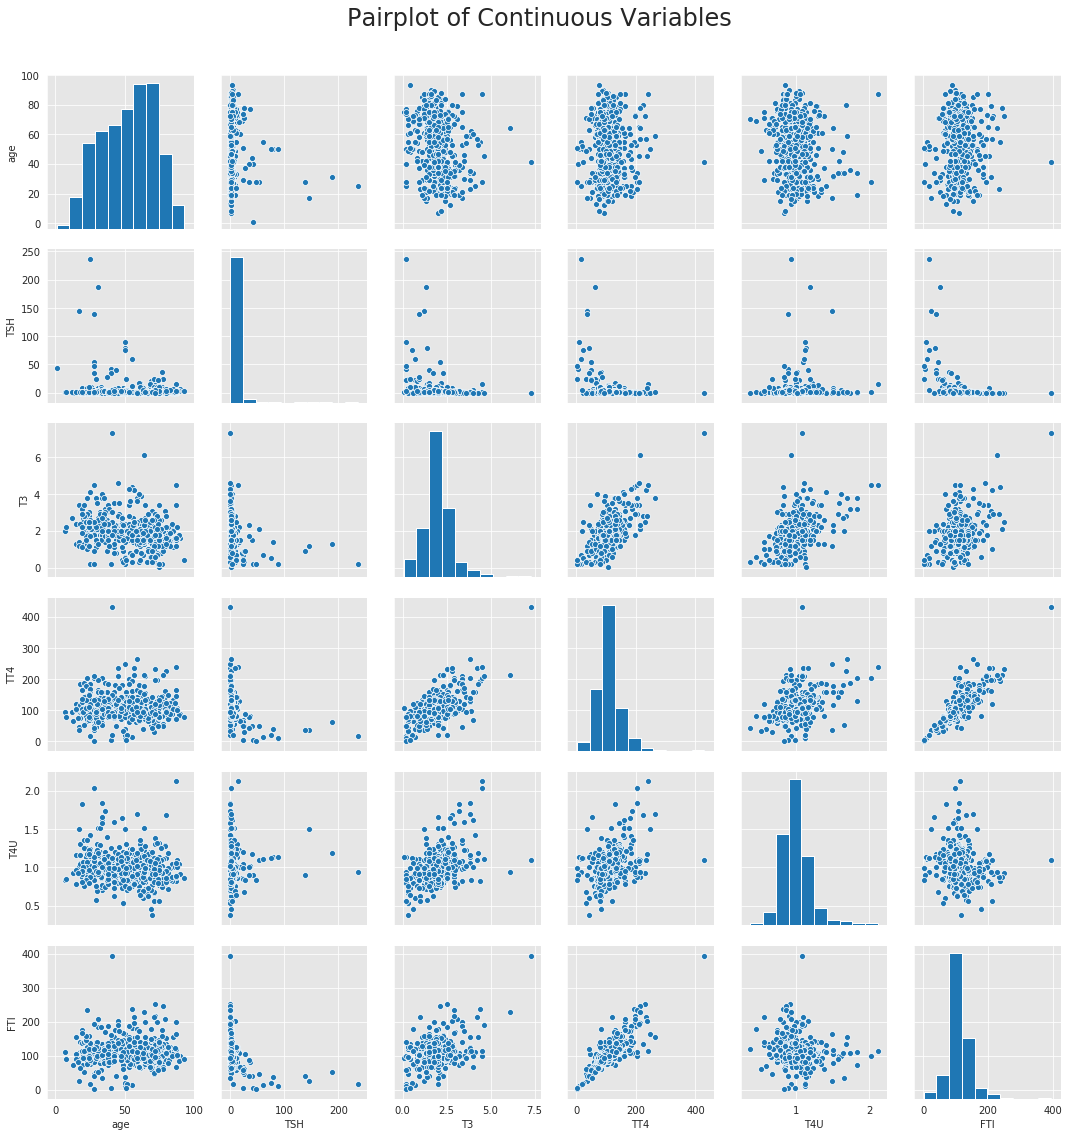

In [11]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.figure(figsize=(20,20))

fig = sns.pairplot(data=df[columns_cont])
fig.fig.suptitle('Pairplot of Continuous Variables', y=1.05, fontsize=24)
fig.savefig('../images/pairplot_continous_variables.png')

In [12]:
# Check Sparsity of data
for c in df.columns: 
    missing = df[c].isna().sum()
    if missing > 0: 
        print('{} - dtype: {}'.format(c, df.dtypes.loc[c]))
        print("missing: {}".format(missing))
        print("percent: {:1.4f}".format((missing/df.shape[0]) * 100))
#     else:
#         print(c)
#         print('No missing values\n')

age - dtype: float64
missing: 1
percent: 0.1656
TSH - dtype: float64
missing: 61
percent: 10.0993
T3 - dtype: float64
missing: 134
percent: 22.1854
TT4 - dtype: float64
missing: 45
percent: 7.4503
T4U - dtype: float64
missing: 74
percent: 12.2517
FTI - dtype: float64
missing: 73
percent: 12.0861
